# Northeast channel water mass

The notebook is to recreate the Northeast channel water mass percentage calculation in detail. Original sources are [Ross et al., 2023](https://gmd.copernicus.org/articles/16/6943/2023/).
and [GFDL CEFI github repository](https://github.com/NOAA-GFDL/CEFI-regional-MOM6/blob/main/diagnostics/physics/NWA12/nechannel.py#L135).

This notebook also utilize the [regional_mom6 package](https://github.com/NOAA-PSL/regional_mom6) 

The water mass calculation will be included into the package for future use.

In [1]:
import xarray as xr
from mom6.mom6_module.mom6_io import MOM6Historical

In [2]:
ds_thetao = MOM6Historical(
    var = 'thetao',
    data_relative_dir = 'hist_run/',
    static_relative_dir = 'static/',
    grid = 'raw',
    source = 'local'
).get_all()

In [3]:
ds_so = MOM6Historical(
    var = 'so',
    data_relative_dir = 'hist_run/',
    static_relative_dir = 'static/',
    grid = 'raw',
    source = 'local'
).get_all()

In [4]:
ds_thetao_opendap = MOM6Historical(
    var = 'thetao',
    grid = 'raw',
    source = 'opendap'
).get_all()

In [5]:
ds_so_opendap = MOM6Historical(
    var = 'thetao',
    grid = 'raw',
    source = 'opendap'
).get_all()

In [6]:
da_theta = ds_thetao.thetao.isel(time=0).load()

## Quick view of the channel box on the map

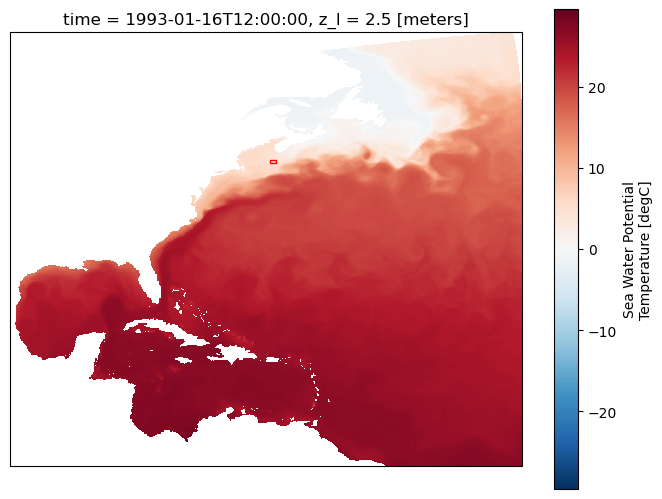

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle

# Define the longitude and latitude range of the rectangle
lon_min, lon_max = -66.8, -66
lat_min, lat_max = 42.2, 42.6

# Create a new matplotlib figure and axes with cartopy projection
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1], projection=ccrs.PlateCarree())
da_theta.isel(z_l=0).plot(x='geolon',y='geolat',ax=ax1)

# Add a rectangle patch
rectangle = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                      edgecolor='red', facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
ax1.add_patch(rectangle)

## Getting the salinity, temperature, and areacello

In [8]:
channel_box = dict(yh=slice(lat_min, lat_max), xh=slice(lon_min, lon_max))

In [13]:
ds_thetao_sub = ds_thetao.sel(**channel_box).compute()
ds_so_sub = ds_so.sel(**channel_box).compute()
ds_sub = xr.merge([ds_thetao_sub.thetao,ds_so_sub.so])
da_area = ds_thetao_sub['areacello']

## Calculate depth weighted mean

In [14]:
import numpy as np
ds_depth_mean = ds_sub.interp(z_l=np.arange(150, 201)).mean('z_l')

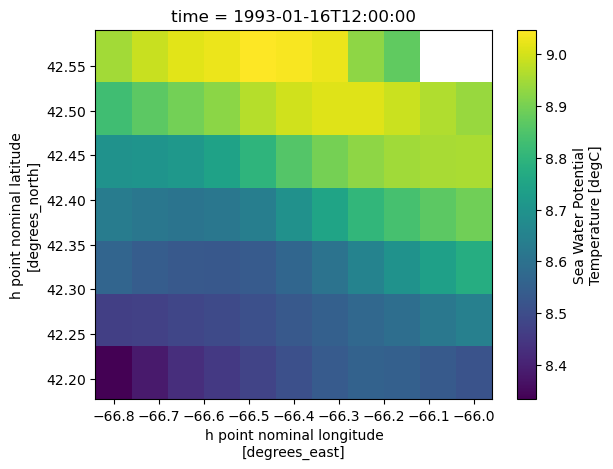

In [73]:
ds_depth_mean.isel(time=0).thetao.plot()

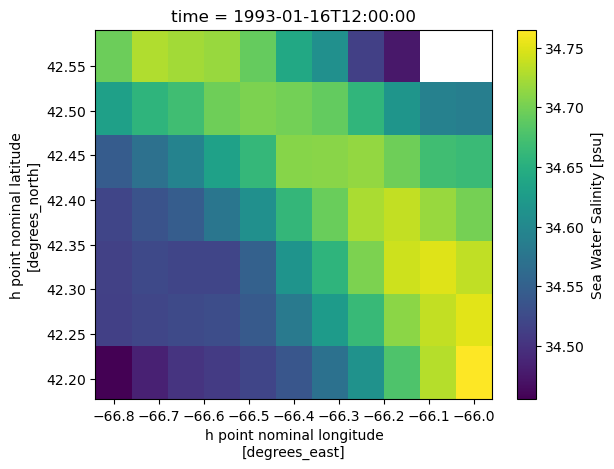

In [74]:
ds_depth_mean.isel(time=0).so.plot()

## Calculate area weighted mean

In [95]:
# masking the area in the denomenator is essential due to missing values in the data 
#  this is to doubel checking the weighted method used in the xarray
ds_aweighted_test = (ds_depth_mean*da_area).sum(['xh','yh'])/(ds_depth_mean/ds_depth_mean*da_area).sum(['xh','yh'])

In [80]:
ds_aweighted = (
        ds_depth_mean
        .weighted(da_area)
        .mean(['xh', 'yh'])
    )

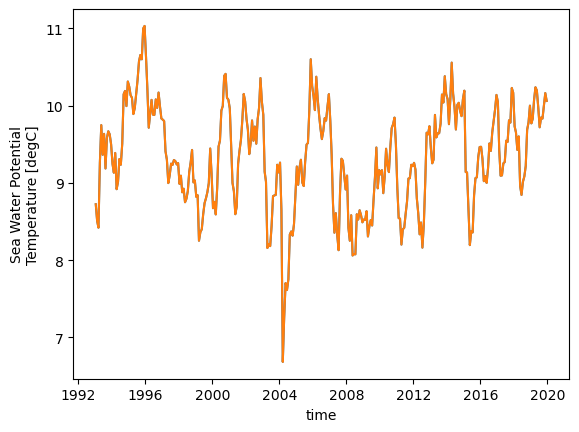

In [81]:
ds_aweighted.thetao.plot()
ds_aweighted_test.thetao.plot()

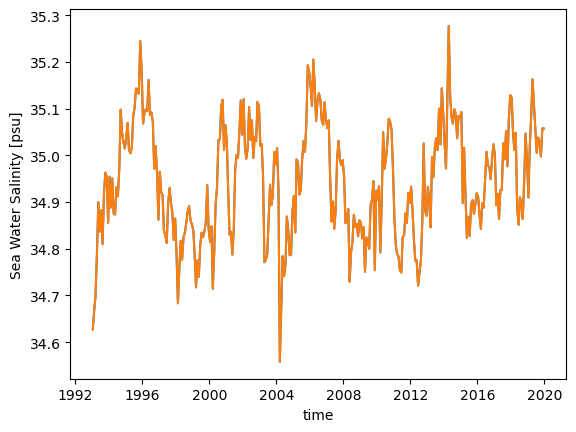

In [82]:
ds_aweighted.so.plot()
ds_aweighted_test.so.plot()

## Calculate the resampled time seires
monthlty to annual

In [84]:
ds_annual = ds_aweighted.resample(time='1AS').mean('time')

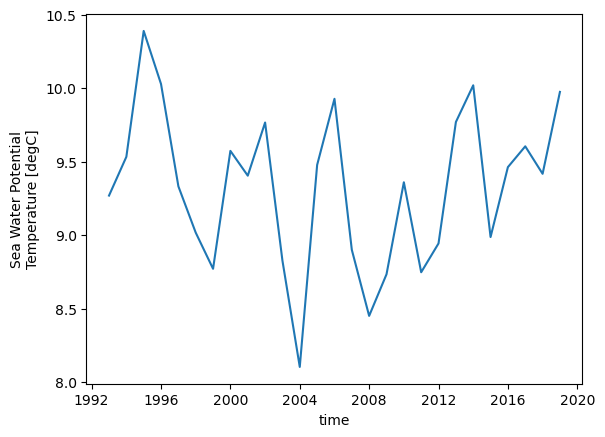

In [85]:
ds_annual.thetao.plot()

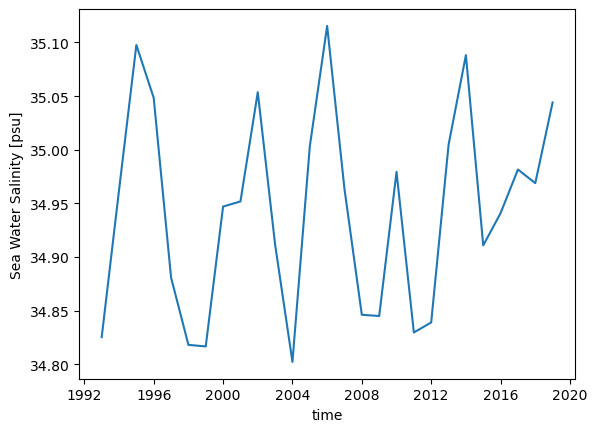

In [86]:
ds_annual.so.plot()

In [87]:
def percent_masses(
        da_temp : xr.DataArray,
        da_salt : xr.DataArray
) -> xr.Dataset:
    """Calculate the percent water mass in the depth-area averaged 
    time series

    Parameters
    ----------
    da_temp : xr.DataArray
        depth-area averaged thetao time series
    da_salt : xr.DataArray
        depth-area averaged so time series

    Returns
    -------
    xr.Dataset
        A dataset contains the percentage water mass from 
        1. SSW : Scotian Shelf Water
        2. WSW : Warm Slope Water
        3. LSW : Labrador Slope Water
    """
    
    # Constant setup 
    ## Scotian Shelf Water (SSW)
    T1 = 2.
    S1 = 32.

    ## Warm Slope Water (WSW)
    T2 = 12.
    S2 = 35.4

    ## Labrador Slope Water (LSW)
    T3 = 6.
    S3 = 34.6

    
    delta = T1 * (S2 - S3) - S1 * (T2 - T3) + T2 * S3 - T3 * S2
    da_m1 = (da_temp * (S2 - S3) + da_salt * (T3 - T2) + T2 * S3 - T3 * S2) / delta
    da_m2 = (da_temp * (S3 - S1) + da_salt * (T1 - T3) + T3 * S1 - T1 * S3) / delta
    da_m3 = (da_temp * (S1 - S2) + da_salt * (T2 - T1) + T1 * S2 - T2 * S1) / delta
    
    da_m1.attrs['units'] = 'percent'
    da_m1.attrs['long_name'] = 'Scotian Shelf Water'
    da_m2.attrs['units'] = 'percent'
    da_m2.attrs['long_name'] = 'Warm Slope Water'
    da_m3.attrs['units'] = 'percent'
    da_m3.attrs['long_name'] = 'Labrador Slope Water'

    return xr.Dataset({'SSW': da_m1, 'WSW': da_m2, 'LSW': da_m3}) * 100 # unit in percent

In [88]:
da_water_mass = percent_masses(ds_annual['thetao'], ds_annual['so'])

Text(0, 0.5, 'water mass (percent)')

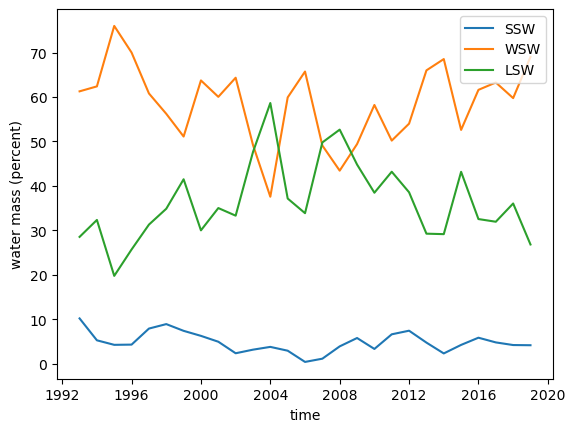

In [94]:
da_water_mass.SSW.plot(label='SSW')
da_water_mass.WSW.plot(label='WSW')
da_water_mass.LSW.plot(label='LSW')
plt.legend(loc=1)
plt.ylabel('water mass (percent)')